# HW_07 Бондаренко Алексей bondaleksey@gmail.com

In [8]:
import pandas as pd
import gzip
import json

Цель данной работы ...

# 1 Данные

## 1.1 Описание данных
 Признаки [набора данных](https://nijianmo.github.io/amazon/index.html)

- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- vote - helpful votes of the review
- style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)
- image - images that users post after they have received the product

In [9]:
### load the meta data
data = []
with gzip.open('data_rs/Software_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

12805
{'overall': 4.0, 'verified': False, 'reviewTime': '10 20, 2010', 'reviewerID': 'A38NELQT98S4H8', 'asin': '0321719816', 'style': {'Format:': ' DVD-ROM'}, 'reviewerName': 'WB Halper', 'reviewText': "I've been using Dreamweaver (and it's predecessor Macromedia's UltraDev) for many years.  For someone who is an experienced web designer, this course is a high-level review of the CS5 version of Dreamweaver, but it doesn't go into a great enough level of detail to find it very useful.\n\nOn the other hand, this is a great tool for someone who is a relative novice at web design.  It starts off with a basic overview of HTML and continues through the concepts necessary to build a modern web site.  Someone who goes through this course should exit with enough knowledge to create something that does what you want it do do...within reason.  Don't expect to go off and build an entire e-commerce system with only this class under your belt.\n\nIt's important to note that there's a long gap from s

In [10]:
df = pd.DataFrame.from_dict(data)
print(len(df))

12805


In [13]:
df.head(20)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,False,"10 20, 2010",A38NELQT98S4H8,0321719816,{'Format:': ' DVD-ROM'},WB Halper,I've been using Dreamweaver (and it's predeces...,A solid overview of Dreamweaver CS5,1287532800,NaN,NaN
1,4.0,False,"10 18, 2010",A3QJU4FEN8PQSZ,0321719816,{'Format:': ' DVD-ROM'},Grimmy,"The demo is done with the PC version, with ref...",A good value,1287360000,NaN,NaN
2,5.0,False,"10 16, 2010",ACJT8MUC0LRF0,0321719816,{'Format:': ' DVD-ROM'},D. Fowler,If you've been wanting to learn how to create ...,This is excellent software for those who want ...,1287187200,3,NaN
3,5.0,False,"10 12, 2010",AYUF7YETYOLNX,0321719816,{'Format:': ' DVD-ROM'},Bryan Newman,I've been creating websites with Dreamweaver f...,A Fantastic Overview of Dream Weaver and Web D...,1286841600,NaN,NaN
4,5.0,False,"10 7, 2010",A31ICLWQ9CSHRS,0321719816,{'Format:': ' DVD-ROM'},Al Swanson,I decided (after trying a number of other prod...,Excellent Tutorials!,1286409600,NaN,NaN
5,5.0,False,"09 26, 2010",A2BVNVJOFXGZUB,0321719816,{'Format:': ' DVD-ROM'},J. Howard,The video is well-paced and delivered in an un...,Excellent.,1285459200,NaN,NaN
6,5.0,False,"04 7, 2011",A2JMJVNTBL7K7E,0321719816,{'Format:': ' DVD-ROM'},Yesuaini99,I spent several hours on the lesson and I love...,excellent video training material,1302134400,NaN,NaN
7,5.0,False,"01 8, 2011",A14JBDSWKPKTZA,0321719816,{'Format:': ' DVD-ROM'},Bob Feeser,I have had Dreamweaver MX2004 since it came ou...,Great Video for a Difficult at Times Program,1294444800,NaN,NaN
8,5.0,False,"10 28, 2010",A2WCFDOCS73PNB,0321719816,{'Format:': ' DVD-ROM'},Gadgetman,I have also taken a local community college on...,Excellent value for the price,1288224000,4,NaN
9,5.0,False,"10 28, 2010",A14638TGYH7GD9,0321719816,{'Format:': ' DVD-ROM'},Rebecca Haden,Even though I use Dreamweaver a great deal and...,Buy this with your copy of Dreamweaver,1288224000,6,NaN


## 1.2 EDA

Число уникальных пользователей

In [15]:
len(pd.unique(df['reviewerID']))

1826

Число уникальных товаров

In [17]:
len(pd.unique(df['asin']))

802

<AxesSubplot:ylabel='Frequency'>

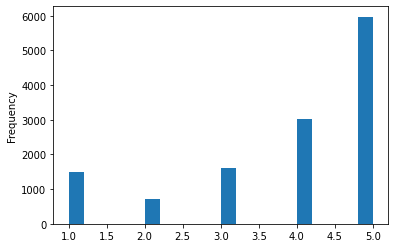

In [16]:
df['overall'].plot.hist(bins = 20);

# 2 Модель

# 3 Оценка прогнозов модели